In [67]:
!pip install fiftyone 


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [65]:
import requests
import zipfile
import os
from urllib.parse import urlparse
import logging
from tqdm import tqdm
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

class FileDownloader:
    def __init__(self, urls, extract_to="./extracted", max_retries=3):
        self.urls = urls
        self.extract_to = os.path.abspath(extract_to)
        self.max_retries = max_retries

    def get_filename_from_url(self, url):
        """
        Extrae el nombre del archivo desde la URL.
        """
        return os.path.basename(urlparse(url).path)

    def download_file(self, url):
        """
        Descarga un archivo desde la URL proporcionada.
        """
        filename = self.get_filename_from_url(url)
        file_path = os.path.join(self.extract_to, filename)

        for attempt in range(1, self.max_retries + 1):
            try:
                logging.info(f"Intento {attempt} de descargar {url}...")
                response = requests.get(url, stream=True)
                response.raise_for_status()

                total_size = int(response.headers.get('Content-Length', 0))
                with open(file_path, "wb") as f, tqdm(
                    total=total_size,
                    unit="B",
                    unit_scale=True,
                    desc=f"Descargando {filename}",
                    dynamic_ncols=True,
                    leave=True,
                    position=0,
                    mininterval=0.5
                ) as pbar:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                        pbar.update(len(chunk))

                logging.info(f"Archivo descargado: {file_path}")
                return file_path
            except Exception as e:
                logging.warning(f"Error al intentar descargar {url}: {e}")
                if attempt == self.max_retries:
                    logging.error(f"Fallaron todos los intentos para descargar {url}.")
                    raise e

    def create_directory(self):
        """
        Crea el directorio de extracción si no existe.
        """
        try:
            os.makedirs(self.extract_to, exist_ok=True)
            logging.info(f"Directorio '{self.extract_to}' creado o ya existente.")
        except OSError as e:
            logging.error(f"No se pudo crear el directorio '{self.extract_to}': {e}")
            raise

    def extract_file(self, zip_path):
        """
        Valida si el archivo descargado es un ZIP válido y lo extrae en una subcarpeta con su nombre.
        Elimina el archivo ZIP después de extraerlo.
        """
        if not zipfile.is_zipfile(zip_path):
            logging.error(f"{zip_path} no es un archivo ZIP válido.")
            raise zipfile.BadZipFile("El archivo descargado no es un ZIP válido.")

        folder_name = os.path.splitext(os.path.basename(zip_path))[0]
        extraction_path = os.path.join(self.extract_to, folder_name)

        logging.info(f"Extrayendo {zip_path} a {extraction_path}...")
        try:
            os.makedirs(extraction_path, exist_ok=True)
            with zipfile.ZipFile(zip_path, "r") as zip_ref:
                zip_ref.extractall(extraction_path)
            logging.info(f"Extracción completada en: {extraction_path}")
        except Exception as e:
            logging.error(f"Error durante la extracción: {e}")
            raise e
        finally:
            os.remove(zip_path)
            logging.info(f"Archivo ZIP eliminado: {zip_path}")

    def execute(self):
        """
        Ejecuta las descargas y extracciones de forma secuencial.
        """
        self.create_directory()
        for url in self.urls:
            try:
                zip_path = self.download_file(url)
                self.extract_file(zip_path)
            except Exception as e:
                logging.error(f"Error al procesar {url}: {e}")

    def list_downloaded_files(self):
        """
        Lista los archivos descargados en el directorio de extracción.
        """
        if not os.path.exists(self.extract_to):
            logging.warning(f"El directorio '{self.extract_to}' no existe.")
            return []

        files = [f for f in os.listdir(self.extract_to) if os.path.isfile(os.path.join(self.extract_to, f))]
        logging.info(f"Archivos descargados: {files}")
        return files

In [71]:
urls = [
    "https://github.com/ankandrew/fast-plate-ocr/releases/download/arg-plates/arg_plate_dataset.zip",
    "https://github.com/ankandrew/fast-plate-ocr/releases/download/arg-plates/arg_plate_dataset_plus_synth.zip"
]

downloader = FileDownloader(urls, extract_to="./")
downloader.execute()
downloader.list_downloaded_files()

2024-11-22 14:26:00,851 - INFO - Directorio '/Users/pepeargentoo/CV_Modelos' creado o ya existente.
2024-11-22 14:26:00,852 - INFO - Intento 1 de descargar https://github.com/ankandrew/fast-plate-ocr/releases/download/arg-plates/arg_plate_dataset.zip...
Descargando arg_plate_dataset.zip: 100%|██████████| 25.4M/25.4M [01:56<00:00, 217kB/s] 
2024-11-22 14:27:59,027 - INFO - Archivo descargado: /Users/pepeargentoo/CV_Modelos/arg_plate_dataset.zip
2024-11-22 14:27:59,029 - INFO - Extrayendo /Users/pepeargentoo/CV_Modelos/arg_plate_dataset.zip a /Users/pepeargentoo/CV_Modelos/arg_plate_dataset...
2024-11-22 14:27:59,966 - INFO - Extracción completada en: /Users/pepeargentoo/CV_Modelos/arg_plate_dataset
2024-11-22 14:27:59,968 - INFO - Archivo ZIP eliminado: /Users/pepeargentoo/CV_Modelos/arg_plate_dataset.zip
2024-11-22 14:27:59,969 - INFO - Intento 1 de descargar https://github.com/ankandrew/fast-plate-ocr/releases/download/arg-plates/arg_plate_dataset_plus_synth.zip...
Descargando arg_pla

['validation_predictions.csv',
 'ClasificadorPatentes.ipynb',
 'README.md',
 '.gitignore',
 'plate_classifier.pth']

# Construccion del Dataset

## Armamos la estrutura

In [70]:
import os

def create_dataset_directory(base_dir="dataset"):
    """
    Crea un directorio base para el dataset con subcarpetas 'train' y 'valid'.
    """
    train_dir = os.path.join(base_dir, "train")
    valid_dir = os.path.join(base_dir, "valid")
    for directory in [base_dir, train_dir, valid_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Directorio '{directory}' creado.")
        else:
            print(f"Directorio '{directory}' ya existe.")
create_dataset_directory()

Directorio 'dataset' creado.
Directorio 'dataset/train' creado.
Directorio 'dataset/valid' creado.


In [72]:
import shutil

def copy_directory_contents(src, dest):
    """
    Copia todo el contenido del directorio de origen al destino.
    Si el archivo ya existe en el destino, lo sobrescribe.
    """
    if not os.path.exists(src):
        print(f"El directorio de origen '{src}' no existe.")
        return

    if not os.path.exists(dest):
        os.makedirs(dest)
        print(f"Directorio de destino '{dest}' creado.")

    for root, dirs, files in os.walk(src):
        for file in files:
            src_file = os.path.join(root, file)
            relative_path = os.path.relpath(src_file, src)
            dest_file = os.path.join(dest, relative_path)
            dest_dir = os.path.dirname(dest_file)
            if not os.path.exists(dest_dir):
                os.makedirs(dest_dir)
            shutil.copy2(src_file, dest_file)
            print(f"Copiado: {src_file} -> {dest_file}")

src = "arg_plate_dataset_plus_synth/arg_plate_dataset/train"
dest = "./dataset/train"
copy_directory_contents(src, dest)
src = 'arg_plate_dataset_plus_synth/arg_plate_dataset/train'
dest = "./dataset/train"
copy_directory_contents(src, dest)
src = "arg_plate_dataset_plus_synth/arg_plate_dataset/valid"
dest = "./dataset/valid"
copy_directory_contents(src, dest)
src = 'arg_plate_dataset_plus_synth/arg_plate_dataset/valid'
dest = "./dataset/valid"
copy_directory_contents(src, dest)

Copiado: arg_plate_dataset_plus_synth/arg_plate_dataset/train/2020-13-08_1354-15_50_7692_JJA417_-P_49.05.png -> ./dataset/train/2020-13-08_1354-15_50_7692_JJA417_-P_49.05.png
Copiado: arg_plate_dataset_plus_synth/arg_plate_dataset/train/2020-15-07_1237-47_26_78.png -> ./dataset/train/2020-15-07_1237-47_26_78.png
Copiado: arg_plate_dataset_plus_synth/arg_plate_dataset/train/2020-15-07_0920-58_16_644.png -> ./dataset/train/2020-15-07_0920-58_16_644.png
Copiado: arg_plate_dataset_plus_synth/arg_plate_dataset/train/2020-15-07_0934-16_16_747.png -> ./dataset/train/2020-15-07_0934-16_16_747.png
Copiado: arg_plate_dataset_plus_synth/arg_plate_dataset/train/2020-16-07_1318-46_17_955.png -> ./dataset/train/2020-16-07_1318-46_17_955.png
Copiado: arg_plate_dataset_plus_synth/arg_plate_dataset/train/A380JFX.jpg -> ./dataset/train/A380JFX.jpg
Copiado: arg_plate_dataset_plus_synth/arg_plate_dataset/train/2020-15-07_0858-34_15_804.png -> ./dataset/train/2020-15-07_0858-34_15_804.png
Copiado: arg_plat

In [73]:
def merge_csv_files(csv1_path, csv2_path, output_path):
    """
    Fusiona dos archivos CSV manejando encabezados duplicados o al final de uno de ellos.
    """
    df1 = pd.read_csv(csv1_path)
    df2 = pd.read_csv(csv2_path)
    common_columns = set(df1.columns).intersection(set(df2.columns))
    if common_columns:
        print(f"Encabezados comunes encontrados: {common_columns}")
    merged_df = pd.concat([df1, df2], ignore_index=True)
    merged_df.to_csv(output_path, index=False)
    print(f"Archivo combinado guardado en: {output_path}")
csv1_path = 'arg_plate_dataset_plus_synth/arg_plate_dataset/train_anotaciones.csv'
csv2_path = 'arg_plate_dataset/arg_plate_dataset/train_anotaciones.csv'
merge_csv_files(csv1_path, csv2_path, 'dataset/train.csv')
csv1_path = 'arg_plate_dataset_plus_synth/arg_plate_dataset/valid_anotaciones.csv'
csv2_path = 'arg_plate_dataset/arg_plate_dataset/valid_anotaciones.csv'
merge_csv_files(csv1_path, csv2_path, 'dataset/valid.csv')

Encabezados comunes encontrados: {'image_path', 'plate_text'}
Archivo combinado guardado en: dataset/train.csv
Encabezados comunes encontrados: {'image_path', 'plate_text'}
Archivo combinado guardado en: dataset/valid.csv


In [75]:
import re

def classify_plate_type(plate_text):
    """
    Clasifica el tipo de patente según su formato.
    """
    try:
        if re.match(r'^[A-Z]{3}\d{3}$', plate_text) or re.match(r'^\d{3}[A-Z]{3}$', plate_text):
            return "vieja"
        elif re.match(r'^[A-Z0-9]{2}\d{2,3}[A-Z0-9]{2,3}$', plate_text):
            return "nueva"
        else:
            return "desconocido"
    except Exception as e:
        print(f"Error al procesar la patente: {plate_text}. Detalles: {e}")
        return "desconocido"

def add_format_column(csv_file):
    """
    Agrega una columna al CSV con el formato clasificado,
    actualiza las rutas de imagen agregando el prefijo 'dataset/',
    y elimina los registros con formato 'desconocido'.
    """
    try:
        df = pd.read_csv(csv_file)
        if 'image_path' not in df.columns or 'plate_text' not in df.columns:
            raise ValueError("El archivo CSV debe contener las columnas 'image_path' y 'plate_text'.")
        df['image_path'] = df['image_path'].apply(lambda x: f"dataset/{x}" if not x.startswith("dataset/") else x)
        df['plate_format'] = df['plate_text'].apply(classify_plate_type)
        df = df[df['plate_format'] != 'desconocido']
        df.to_csv(csv_file, index=False)
        print(f"Archivo actualizado sin registros 'desconocido' y con rutas corregidas en: {csv_file}")
    except Exception as e:
        print(f"Error al procesar el archivo CSV. Detalles: {e}")

add_format_column("dataset/train.csv")
add_format_column("dataset/valid.csv")

Archivo actualizado sin registros 'desconocido' y con rutas corregidas en: dataset/train.csv
Archivo actualizado sin registros 'desconocido' y con rutas corregidas en: dataset/valid.csv


# Visualizacion del Dataset

In [92]:
import fiftyone as fo
import pandas as pd
import os

csv_file = "dataset/train.csv"
image_dir = "."

data = pd.read_csv(csv_file)

dataset_name = "dataset_from_csv"

if dataset_name in fo.list_datasets():
    fo.delete_dataset(dataset_name)

dataset = fo.Dataset(dataset_name)
for _, row in data.iterrows():
    image_path = os.path.join(image_dir, row["image_path"])
    if not os.path.exists(image_path):
        print(f"Imagen no encontrada: {image_path}")
        continue 
    sample = fo.Sample(filepath=image_path)
    sample["ground_truth"] = fo.Classification(label=row["plate_format"])
    dataset.add_sample(sample)
print(f"Dataset cargado con {len(dataset)} muestras.")

Dataset cargado con 6392 muestras.


In [100]:
session = fo.launch_app(dataset, port=8080)
print(session.url)

http://localhost:8080/


Distribución de clases en el dataset:
vieja: 3314
nueva: 3078


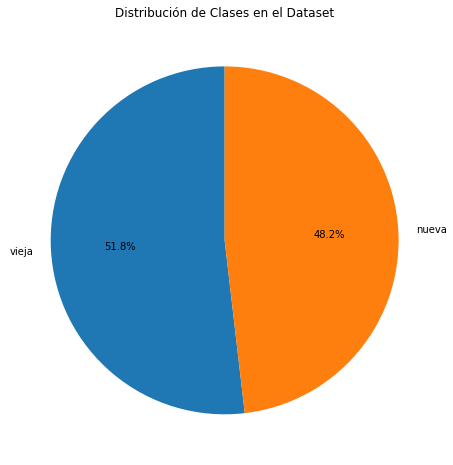

In [101]:
import fiftyone as fo
import matplotlib.pyplot as plt

# Cargar el dataset si aún no lo has hecho
dataset = fo.load_dataset("dataset_from_csv")  # Reemplaza con el nombre de tu dataset

# Contar la cantidad de variables en cada clase
class_distribution = dataset.count_values("ground_truth.label")

# Mostrar los resultados
print("Distribución de clases en el dataset:")
for label, count in class_distribution.items():
    print(f"{label}: {count}")

# Crear un gráfico de torta para visualizar la distribución de clases
plt.figure(figsize=(8, 8))
plt.pie(
    class_distribution.values(),
    labels=class_distribution.keys(),
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Distribución de Clases en el Dataset")
plt.show()


In [32]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch import nn, optim
from torchvision import models
from torchvision.models import ResNet18_Weights
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

class LicensePlateDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Dataset personalizado para patentes.
        """
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['plate_format'] != 'desconocido']  # Ignorar desconocidos
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        label = 0 if row['plate_format'] == 'vieja' else 1  # 0: vieja, 1: nueva
        if self.transform:
            image = self.transform(image)
        return image, label


In [33]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = LicensePlateDataset("dataset/train.csv", transform=transform)
valid_dataset = LicensePlateDataset("dataset/valid.csv", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [37]:
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_accuracy(loader, model):
    """
    Calcula la precisión en un conjunto de datos.
    """
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad():  
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

Epoch 1/5


Training: 100%|██████████| 200/200 [04:47<00:00,  1.44s/it, Loss=0.043] 


Epoch 1/5, Loss: 0.0430, Train Accuracy: 99.97%, Valid Accuracy: 100.00%
Epoch 2/5


Training: 100%|██████████| 200/200 [04:53<00:00,  1.47s/it, Loss=0.0114] 


Epoch 2/5, Loss: 0.0114, Train Accuracy: 99.47%, Valid Accuracy: 100.00%
Epoch 3/5


Training: 100%|██████████| 200/200 [04:49<00:00,  1.45s/it, Loss=0.00705]


Epoch 3/5, Loss: 0.0070, Train Accuracy: 99.97%, Valid Accuracy: 100.00%
Epoch 4/5


Training: 100%|██████████| 200/200 [04:48<00:00,  1.44s/it, Loss=0.000415]


Epoch 4/5, Loss: 0.0004, Train Accuracy: 100.00%, Valid Accuracy: 100.00%
Epoch 5/5


Training: 100%|██████████| 200/200 [04:59<00:00,  1.50s/it, Loss=6.38e-5]


Epoch 5/5, Loss: 0.0001, Train Accuracy: 100.00%, Valid Accuracy: 100.00%
Modelo guardado como 'plate_classifier.pth'


# Entrenamiento con barra de progreso y evaluación

In [ ]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc="Training", leave=True)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"Loss": running_loss / len(train_loader)})
    train_accuracy = calculate_accuracy(train_loader, model)
    valid_accuracy = calculate_accuracy(valid_loader, model)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Valid Accuracy: {valid_accuracy:.2f}%")

# Guardar el modelo entrenado

In [ ]:
torch.save(model.state_dict(), "plate_classifier.pth")
print("Modelo guardado como 'plate_classifier.pth'")

Predicciones guardadas en 'validation_predictions.csv'


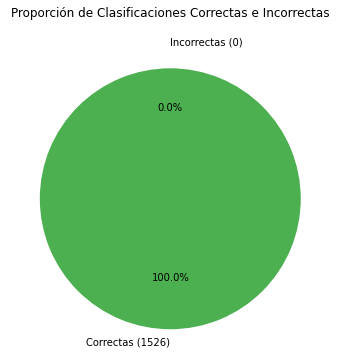

In [44]:
# Función para cargar el modelo entrenado
def load_model(model_path):
    """
    Carga el modelo guardado desde un archivo .pth.
    """
    model = models.resnet18()
    model.fc = torch.nn.Linear(model.fc.in_features, 2)  # Dos clases: vieja, nueva
    model.load_state_dict(torch.load(model_path))  # Cargar pesos entrenados
    model = model.to(device)
    model.eval()  # Cambiar el modelo a modo evaluación
    return model

# Función para clasificar imágenes desde el dataset de validación
def classify_images_from_csv(csv_file, model, class_names):
    """
    Clasifica imágenes desde un archivo CSV con rutas y etiquetas verdaderas.
    
    Args:
        csv_file (str): Ruta del archivo CSV con columnas 'image_path' y 'plate_format'.
        model (torch.nn.Module): Modelo entrenado.
        class_names (list): Nombres de las clases (e.g., ['vieja', 'nueva']).
    
    Returns:
        list: Lista de resultados con predicción y etiqueta verdadera.
    """
    data = pd.read_csv(csv_file)
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    results = []
    label_map = {'vieja': 0, 'nueva': 1}  # Mapear etiquetas a índices
    
    for _, row in data.iterrows():
        image_path = row['image_path']
        true_label = label_map[row['plate_format']]
        
        # Cargar y transformar la imagen
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        # Realizar predicción
        with torch.no_grad():
            outputs = model(image_tensor)
            _, predicted_label = torch.max(outputs, 1)
        
        results.append({
            "image_path": image_path,
            "true_label": class_names[true_label],
            "predicted_label": class_names[predicted_label.item()],
            "is_correct": true_label == predicted_label.item()  # Correcto o incorrecto
        })
    
    return results

# Función para generar gráfico de torta
def plot_pie_chart(results):
    """
    Genera un gráfico de torta con la proporción de clasificaciones correctas e incorrectas.
    """
    correct = sum(1 for result in results if result["is_correct"])
    incorrect = len(results) - correct
    
    labels = [f'Correctas ({correct})', f'Incorrectas ({incorrect})']
    sizes = [correct, incorrect]
    colors = ['#4CAF50', '#F44336']  # Verde para correctas, rojo para incorrectas
    explode = (0.1, 0)  # Separar ligeramente el segmento de correctas

    plt.figure(figsize=(8, 6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Proporción de Clasificaciones Correctas e Incorrectas')
    plt.show()

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "plate_classifier.pth"
csv_file = "dataset/valid.csv"
class_names = ["vieja", "nueva"]

# Cargar el modelo entrenado
model = load_model(model_path)

# Clasificar imágenes desde el dataset de validación
results = classify_images_from_csv(csv_file, model, class_names)

# Guardar los resultados en un archivo CSV
results_df = pd.DataFrame(results)
results_df.to_csv("validation_predictions.csv", index=False)
print("Predicciones guardadas en 'validation_predictions.csv'")

# Generar gráfico de torta
plot_pie_chart(results)
